### Реализаця классического генетического алгоритма

|![Algo_scheme](algo.svg "Этапы классического ГА")|
|-------------------------------------------------|

#### Функция: $(1.85-x)cos(3.5x-0.5)$

In [1]:
import numpy as np
from collections import Iterable
from scipy.optimize import newton
import plotly
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

In [2]:
def f(x): return (1.85-x)*np.cos(3.5*x-0.5)

Зададим основные параметры генетического алгоритма (далее - ГА). К таковым относятся: размер популяции, вероятность скрещивания, произведения потомства, мутации, мера мутации, область определения целевой функции, точность вычислений.

In [3]:
crossing_prob = 0.95
mutation_prob = 0.05
matation_rate = 1
progeny_prob = 0.95

initial_population_size = 1000
target_function = f
domain = np.array([-10,10])

int_part = len(bin(max(abs(domain[0]),abs(domain[1])))[2:])
frac_signs = 5
frac_part = len(bin(int(''.join(['9' for i in range(frac_signs)])))[2:])

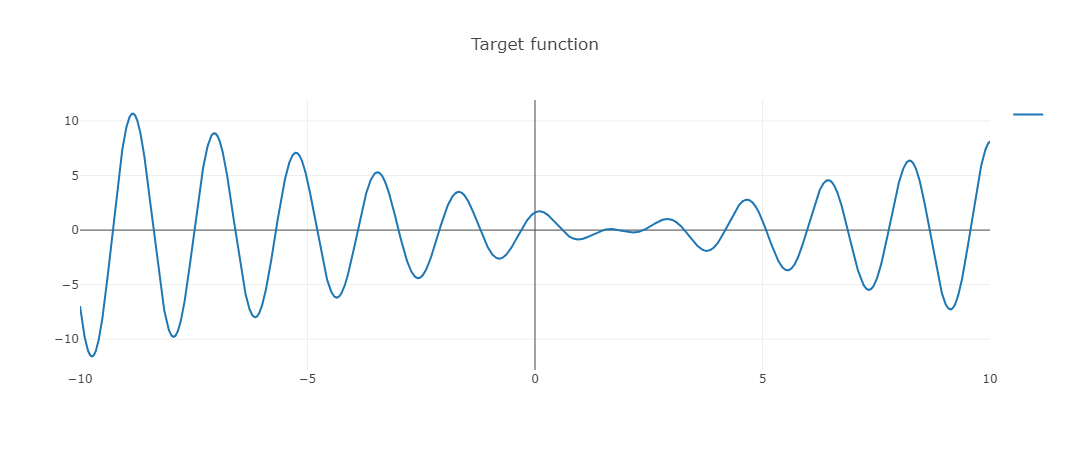

In [4]:
xs = np.linspace(-10,10,10000)
ys = f(xs)

plot = go.Scatter(dict(x= xs, y= ys, name='$(1.85-x)cos(3.5x-0.5),  x \in [-10, 10]$'))

fig = go.Figure({'data': [plot],
         'layout': {'showlegend': True,
                   'title': 'Target function',}})
py.iplot(fig)

Представленный алгоритм работает только для неотрицаnельных функций, поэтому необходимо преобразовать целевую функцию.

Найдем нули целевой функции методом Ньютона:

In [5]:
def get_roots(f, domain):
    xs = np.linspace(domain[0],domain[1], 10000)
    ys = f(xs)

    roots = []
    sign = np.sign(ys[0])

    for i in range(ys.size):
        if np.sign(ys[i]) != sign:
            sign *= -1
            try:
                roots.append(newton(f,xs[i]))
            except RuntimeError: pass

    return roots

Пусть $f(x)$ - целевая функция. Разложим $f(x): f(x) =
\begin{equation*}
\begin{cases}
f^+(x) = f(x), f(x) > 0,
\\
f^-(x) = f(x), f(x) < 0 
\end{cases}
\end{equation*}
$

In [6]:
def function_decompozition(f,domain):
    roots = get_roots(f,domain)
    decomposed = {'plus': [], 'minus': []}
    eps = 0.001
    if roots[0] != domain[0]:
        if f(roots[0] - eps) < 0:
            decomposed['minus'].append((domain[0], roots[0]))
        else:
            decomposed['plus'].append((domain[0],roots[0]))
            
    for i in range(1,len(roots)):
        if f(roots[i] - eps) < 0:
            decomposed['minus'].append((roots[i-1], roots[i]))
        else:
            decomposed['plus'].append((roots[i-1],roots[i]))
            
    if roots[-1] != domain[1]:
        if f(roots[-1] + eps) < 0:
            decomposed['minus'].append((roots[-1], domain[1]))
        else:
            decomposed['plus'].append((roots[-1],domain[1]))
            
    return decomposed

Разложение области определения на промежутки знакопостоянства функции и выбор необходимых для решения задачи:

In [7]:
def reduce_domain(f, domain, opt_type='max'):
    decomposed_f = function_decompozition(f,domain)
    if opt_type == 'max':
        return (np.array(decomposed_f['plus']),'max') if decomposed_f['plus'] else (np.array(decomposed_f['minus'])*(-1), 'min')
    else:
        return (np.array(decomposed_f['minus'])*(-1),'max') if decomposed_f['minus'] else (np.array(decomposed_f['plus']), 'min')

Ниже реализован подсчёт функции с учетом особенностей задачи - если аргумент принадлежит области определения, вычисляем функцию, иначе - 0

In [8]:
def in_domain(x, domain):
    if isinstance(domain[0], Iterable):
        for i in domain:
            if i[0] <= x <= i[1]: return True
        return False
    else: return domain[0] <= x <= domain[1]

def compute_f(x,domain):
        
    if not isinstance(x, Iterable):
        return f(x) if in_domain(x,domain) else 0
    res = []
    for i in x:
        res.append(f(i) if in_domain(i,domain) else 0)
        
    return np.array(res)



Для представления генотипов используем двоичный код: отдельно кодируем целую и дробную части. 

In [9]:
def to_custom_bin(n, int_part=int_part, frac_part=frac_part, frac_signs=frac_signs): 
    rep = str(n)
    if '.' in rep:
        int_repr = rep[:rep.find('.')]
        int_code = bin(abs(int(int_repr)))[2:]
        sign = '1' if n < 0 else '0'
        int_code = sign+'0'*(int_part-len(int_code)) + int_code
        
        frac_repr = rep[rep.find('.')+1:]
        frac_repr = frac_repr[:frac_signs]
        frac_code = bin(int(frac_repr))[2:]
        frac_code = '0'*(frac_part - len(frac_code)) + frac_code
        
        code = int_code+frac_code
    else:
        int_code = bin(abs(int(rep)))[2:]
        int_code = '0'*(int_part-len(int_code)) + int_code
        sign = '1' if n < 0 else '0'
        code = sign+int_code[1:] + '0'*frac_part
    

        
    return code

def from_custom_bin(code, int_part=int_part):
    int_repr = code[1:int_part+1]
    sign = 1 if code[0] == '0' else -1
    int_dec = sign*int(int_repr, 2)
    

    frac_repr = code[int_part+1:]
    if frac_repr:
        frac_dec = int(frac_repr,2)
    else: frac_part = 0
    
    return float(str(int_dec)+'.'+str(frac_dec))

Однако задача должна решаться с принятием во внимание принципа компактности - "похожие" особи находятся рядом. Данную проблему решает код Грея:

In [10]:
def bin_to_gray(num): # num is string
    gray = num[0]
    for i in range(1,len(num)):
        gray += bin(int(num[i-1],2)+int(num[i],2))[-1]
    return gray

def gray_to_bin(gray):
    tmp = gray[0]
    num = tmp
    for i in range(1,len(gray)):
        if gray[i] == '1': tmp = bin(not(int(tmp,2)))[-1]
        num += tmp
    return num

За начальную популяцию примем равномерное разбиение области определения.

In [11]:
def init_population(size=initial_population_size, domain=domain):
    phenotypes = np.linspace(domain[0],domain[1],size)
    return phenotypes

def to_phenotypes(pop):
    return np.array(list(map(lambda x: from_custom_bin(gray_to_bin(x)), pop)))

def to_genotypes(pop):
    return np.array(list(map(lambda x: bin_to_gray(to_custom_bin(x)), pop)))

В качестве фитнесс-функции используем преобразованную целевую:

In [12]:
def fitness_calc(phenotypes, domain=domain): return compute_f(phenotypes, domain)

Селекцию будем проводить методом рулетки. $v(x_k) = \frac {f(x_k)}{\sum_{i=1}^n f(x_i) \quad}$, где $v(x)$ - фитнесс-функция, $x_i$ - особи популяции, $k$ - номер текущей особи. Таким образом получаем распределение случайной величины - выбора данной особи для применения послежующих операторов.

In [13]:
def roulette(population, opt_type='max', domain=domain): #phenos
    av = np.sum(fitness_calc(population, domain))
    probas = fitness_calc(population, domain)/av
    if opt_type == 'min':
        probas = np.max(probas) + np.min(probas) - probas
    return np.array([np.random.choice(population, p=probas) for i in range(len(population))])

Оператор скрещивания - единичный кроссинговер. Случайно выбирается пара особей, случайно выбирается одна точка кроссинговера. В результате получим две особи-потомка - с головой первого родителя и хвостом второго, и, наоборот, с головой второго и хвостом первого.

In [14]:
def random_pick(population):
    rest = population
    picked = []
    while len(rest):
        rand_idxs = np.random.randint(0, len(rest), 2)
#         print (rand_idxs[0] == rand_idxs[1])
        if len(rest) == 2: rand_idxs=np.array([0,1])
        while rand_idxs[0] == rand_idxs[1]:
            rand_idxs = np.random.randint(0, len(rest), 2)
        picked.append((rest[rand_idxs[0]], rest[rand_idxs[1]]))
        rest = np.delete(rest, rand_idxs)
    return picked

def standard_crossover(p1, p2): #p1, p2 are genotypes
    crossingover_point = np.random.randint(2,len(p1)-2)
    return (p1[:crossingover_point]+p2[crossingover_point:], p2[:crossingover_point]+p1[crossingover_point:])

def crossover_op(population, proba): #population is genotypes
    pairs = []
    progeny = np.array([])
    pairs = random_pick(population)

    progeny = np.append(progeny, np.array(list(map(lambda x: standard_crossover(x[0],x[1]), pairs))))
    progeny = progeny[np.random.random(len(progeny))<proba]
    
    return progeny.flatten()

Оператор мутации - инверсия некоторого количества случайных бит в генотипе особи. Это количесво будем называть <i> мерой</i> мутации. Также стоить отметить, что мутация происходит с некоторой вероятностью.

In [15]:
def random_bit(p):
    bit_pos = np.random.randint(0,len(p))
    bit_val = '1' if p[bit_pos] == '0' else '0'
    return p[:bit_pos] + bit_val + p[bit_pos+1:]

def mutation_op(population, proba, mutation_measure=2): #measure is amount of bits to be changed
    for i in range(len(population)):
        for j in range(mutation_measure):
            if np.random.random()<proba:
                population[i] = random_bit(population[i])
            
    return population

Далее описана проверка принадлежности фенотипа особи области определения и расширения популяции после применения опреаторов до размеров исходной. Оскудевание популяции является следствием случайного выбора хромосомы для мутации и точки кроссинговера. Дополнение популяции происходит особями из предыдущего поколения.

In [16]:
def check_domain(population, domain=domain):#phenotypes
    return population[np.bitwise_and(domain[0] < population, domain[1] > population)]

def extend_progeny(old_pop, progeny): #phenotypes
    return np.append(progeny, old_pop[np.random.randint(0,len(old_pop), len(old_pop)-len(progeny))])

Критерий останова алгоритма определим следущим образом - если дисперсия популяции меньше $\epsilon$, то прекращаем работу алгоритма. Принимая во внимание возможность наличия выбросов, будем считать дисперсию на 80% выборки (доля определена эмпирически). Результат - максимум на последней популяции.

In [27]:
def stop(population, eps=0.01): #pheno
    av = np.sum(population)/population.size
    goods = 0
    for i in population:
        if (i-av)**2 <= eps: goods += 1

    return True if goods/population.size >= 0.8 else False

Далее описана функция интерактивного вывода

In [49]:
def interactive(domain, data, result):
   
    figure = {
    'data': [],
    'layout': {},
    'frames': []
    }
    
    figure['layout']['xaxis'] = {'range': (domain[0], domain[1]),'title': 'x'}
    figure['layout']['yaxis'] = {'range': (-abs(result[1])-2, abs(result[1])+2),'title': 'y'}
    
    
    figure['layout']['updatemenus'] = [
        {
            'buttons': [
                {
                    'args': [None, {'transition': 300}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': ['null', {'mode': 'immediate'}],
                    'label': 'Pause',
                    'method': 'animate',
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]
    
    
    
    function = {
        'x' : np.linspace(domain[0], domain[1], 1000),
        'y' : f(np.linspace(domain[0], domain[1], 1000)),
        'name' : 'target function'
    }
    figure['data'].append(function)
    
       
    data_dict = {
        'x': data[0],
        'y': compute_f(data[0], domain),
        'mode': 'markers',
        'marker':{
            'size': 5,
            'symbol': 'diamond',
            'color': '#FF00FF',
            'opacity': 0.7
            },
        }
                         
        
    figure['data'].append(data_dict)
    
    
    for epoch in data:
        frame = {'data': [function], 'name': epoch}
        data_dict = {
            'x': data[epoch],
            'y': compute_f(data[epoch], domain),
            'mode': 'markers',
            'marker':{
                'size': 5,
                'symbol': 'diamond',
                'color': '#FF00FF'
                },
            'name': 'frame'+str(epoch)
        }   
        frame['data'].append(data_dict)
        
        figure['frames'].append(frame)
        
    res_dot = {
        'x': [result[0]],
        'y': [result[1]],
        'name': 'best value',
        'mode': 'markers',
        'marker': {
            'size': 20,
            'color': '#00FF40',
            'symbol': 'star-diamond'
        }
    }
    
    frame = {'data': [function, res_dot,], 'name': 'res'}
    figure['frames'].append(frame)
    
        
    iplot(figure)
    

И запуска алгоритма:

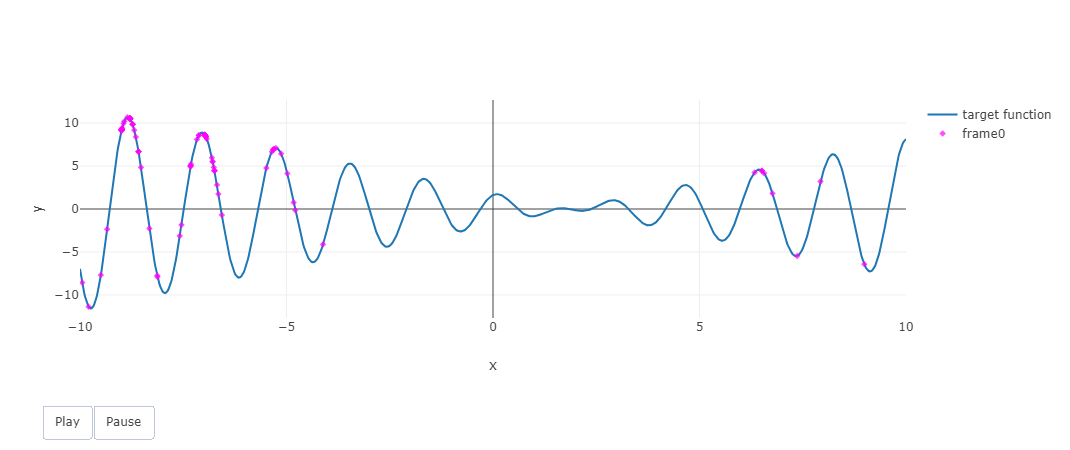

Прошло поколений:  101
Максимальное значение f(x) равно  10.68694
Достигается при x =  -8.8405


In [50]:
def run():
    reduced_domain, opt_type = reduce_domain(f,domain)
    population = init_population(100)
    data = {0:[]}
    data[0] = population
    n_iters = 0
    
    while not stop(population):
        selected = roulette(population, opt_type, reduced_domain)
        selected_as_genes  = to_genotypes(selected)
        progeny = crossover_op(selected_as_genes, crossing_prob)
        mutated = mutation_op(progeny, mutation_prob)
        reduced_pop = check_domain(to_phenotypes(mutated), domain)
        population = extend_progeny(selected, reduced_pop)
        data[len(data) - n_iters] = population
        n_iters += 1
    
    dtype = [('x', float),('y', float)]
    mmap = np.array(list(zip(population, f(population))), dtype=dtype)
    mmap.sort(order='y')
    res = mmap[-1]
    interactive(domain, data, res)
    
    print ("Прошло поколений: ", n_iters)
    return res

result = run()
print ("Максимальное значение f(x) равно ", round(result[1],5))
print ("Достигается при x = ", result[0])